#### Lake level extraction by using swot_l2_hr_pixc data 
具体步骤：（1）data reading ->（2）masking of non-lake region ->（3）geophysical correction and elevation reference conversion ->（4）outliers removing ->（5）Lake level calculation ->（6）time-series data processing




In [55]:
import os
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scripts.utils import IQR_filter
from pyrsimg import readTiff, imgShow


In [56]:
dir_save_pixc = 'data/dianchi_lake/pixc'
path_dianchi_vec = 'data/dianchi_lake/dianchi_vector.gpkg'
path_img = 'data/rsimg/dianchi_s2_20200511_wgs84.tif'


#### (1) swot pixc data reading and checking

In [57]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_save_pixc, file) for file in os.listdir(dir_save_pixc) if 'PIXC_' in file and '.nc' in file]
paths_file = sorted(paths_file)
id = 0
print(paths_file[id])
## read one pixc data 
pixc_nc = xr.open_dataset(paths_file[id], group='pixel_cloud')
pixc_nc


data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PGC0_01.nc


<xarray.Dataset>
Dimensions:                                (points: 4712700, complex_depth: 2,
                                            num_pixc_lines: 3282)
Coordinates:
    latitude                               (points) float64 ...
    longitude                              (points) float64 ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 ...
    range_index                            (points) float64 ...
    interferogram                          (points, complex_depth) float32 ...
    power_plus_y                           (points) float32 ...
    power_minus_y                          (points) float32 ...
    coherent_power                         (points) float32 ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 ...
    data_window_first_valid                (num_pixc_lines) float64 ...
    data_window_last_valid                 (num_pixc_lines) float64 ...
    data_window_first_cross_track          (num_pixc_lines) float32 ...
    data_window_last_cross_track           (num_pixc_lines) float32 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3282
    interferogram_size_range:    5016
    looks_to_efflooks:           1.5534686409936909
    num_azimuth_looks:           7.0
    azimuth_offset:              9

In [58]:
## auxiliary data
## read remote sensing image
rsimg_io = readTiff(path_img)
## read vector file of the lake.
dianchi_gpd = gpd.read_file(path_dianchi_vec)
dianchi_gpd


,Name,geometry
0,dianchi,"POLYGON Z ((102.66614 24.83805 0.00000, 102.65..."


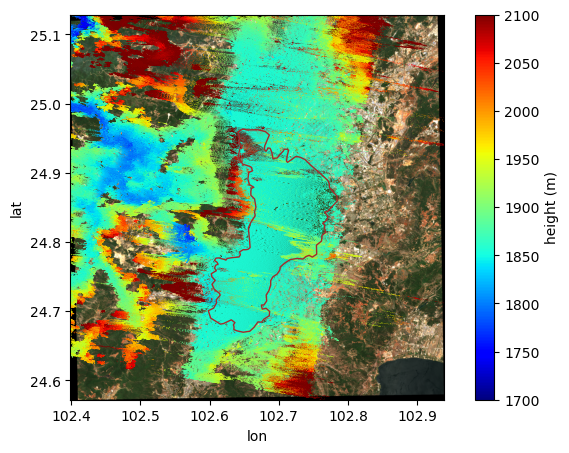

In [81]:
# mask = np.where(pixc_nc.geolocation_qual <= 4096)
# print(mask[0].shape)
fig, ax = plt.subplots(figsize=(8,5))
scat = ax.scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height,
           s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=1)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')


#### （2）Select pixel cloud data of the given lake region.

In [61]:
def height_cor(pixc_nc):
    """geophysical corrections for the height data.
       ! no inverse barometric correction.
    """
    height = pixc_nc.height.values
    solid_tide = pixc_nc.solid_earth_tide.values
    pole_tide = pixc_nc.pole_tide.values
    load_tide = pixc_nc.load_tide_fes.values
    iono_corr = pixc_nc.iono_cor_gim_ka.values
    return height - (solid_tide + pole_tide + load_tide + iono_corr)    

heights_cor = height_cor(pixc_nc=pixc_nc)
heights_cor = heights_cor - pixc_nc.geoid.values   ## to egm2008 height


#### （3）mask out non-lake region.


In [62]:
## convert pixel cloud to shapely.Point object.
lat = pixc_nc['latitude'].values
lon = pixc_nc['longitude'].values
points = list(zip(lon, lat))
points = [Point(point) for point in points]


In [63]:
mask_region = dianchi_gpd.geometry[0].contains(np.array(points))
lon_region = np.ma.masked_array(lon, mask=~mask_region, fill_value=np.nan)
lat_region = np.ma.masked_array(lat, mask=~mask_region, fill_value=np.nan)
heights_region = np.ma.masked_array(heights_cor, mask=~mask_region, fill_value=np.nan)


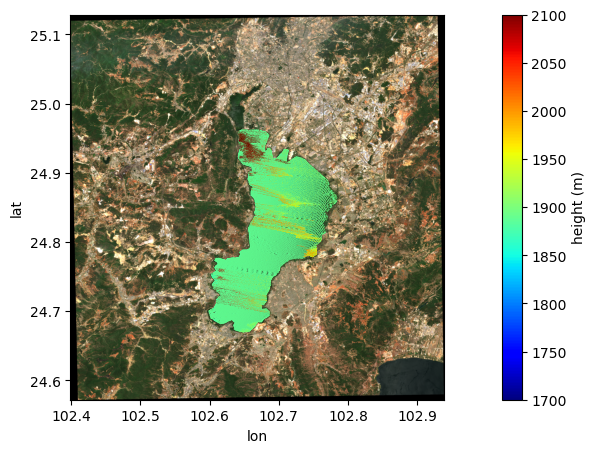

In [64]:
rsimg_io = readTiff(path_img)
crs='EPSG:4326'
fig, ax = plt.subplots(figsize=(15,5))
scat = ax.scatter(x=lon_region[~lon_region.mask], y=lat_region[~lat_region.mask], \
                  c=heights_region[~heights_region.mask], s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
# dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon'); ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')


#### (4) Outlier removing using IQR method.

In [65]:
heights_region_IQR, IQR = IQR_filter(heights_region.filled(np.nan))
heights_region_IQR.mask = heights_region_IQR.mask | heights_region.mask
while IQR > 0.3:
    print(IQR)
    heights_region_IQR_mask = heights_region_IQR.mask
    heights_region_IQR, IQR = IQR_filter(heights_region_IQR.filled(np.nan))
    heights_region_IQR.mask = heights_region_IQR.mask | heights_region_IQR_mask
print(IQR)


33.49700927734375
0.183837890625


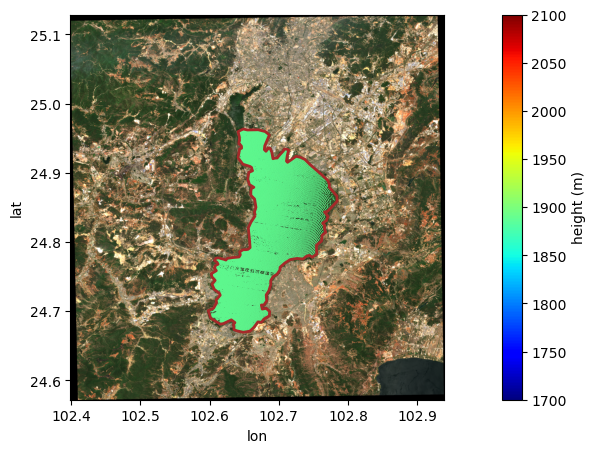

In [66]:
rsimg_io = readTiff(path_img)
crs='EPSG:4326'
fig, ax = plt.subplots(figsize=(15,5))
scat = ax.scatter(x=lon[~heights_region_IQR.mask], y=lat[~heights_region_IQR.mask], \
                  c=heights_cor[~heights_region_IQR.mask], s=0.1, edgecolor='none', cmap='jet', clim=(1700, 2100))
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
imgShow(rsimg_io.array, extent=rsimg_io.geoextent, ax=ax)
ax.set_xlabel('lon'); ax.set_ylabel('lat')
fig.colorbar(scat).set_label('height (m)')


#### (5) Lake level extraction (the mean and std values of the heights)  

In [67]:
### area weighting heights
def area_averaged(heights, areas):
  pixel_heights_sum = np.sum(areas*heights)
  pixel_AreaWeighted_height = pixel_heights_sum/np.sum(areas)
  weighted_var = [(heights[i] - pixel_AreaWeighted_height)**2*areas[i] for i in range(heights.shape[0])]
  weighted_var_sum = np.sum(weighted_var)
  weighted_std = np.sqrt(weighted_var_sum/sum(areas))
  return pixel_AreaWeighted_height, weighted_std

pixel_area = pixc_nc.pixel_area.values
pixel_height_ = heights_cor[~heights_region_IQR.mask]
pixel_area_ = pixel_area[~heights_region_IQR.mask]
pixel_AreaWeighted_height, weighted_dev = area_averaged(heights=pixel_height_, areas=pixel_area_)
print('Area Weighted height:', pixel_AreaWeighted_height)
print('Area Weighted deviation: ', weighted_dev)


Area Weighted height: 1887.7084
Area Weighted deviation:  0.11711038111545136


#### (6) time-series processing for the pixc data.

In [68]:
## get acquisition time 
date_data = [path.split('_')[-4][0:8] for path in paths_file]
date_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8] for date in date_data]
print(date_data)


['2024-01-05', '2024-01-26', '2024-02-16', '2024-03-08', '2024-03-29', '2024-04-19', '2024-05-10', '2024-05-30', '2024-06-20']


In [ ]:
heights_dianchi_mean, heights_dianchi_std = {}, {}
for i, path in enumerate(paths_file):
  print(i, path)
  date = date_data[i]
  ## (1) data reading
  pixc_nc = xr.open_dataset(path, group='pixel_cloud')
  ## (2) geophysical corrections and convert to egm2008 height.
  heights_cor = height_cor(pixc_nc=pixc_nc)
  heights_cor =  heights_cor - pixc_nc.geoid.values  ## to egm2008 height  
  ## (3) mask out non-lake region.
  lat, lon = pixc_nc.latitude.values, pixc_nc.longitude.values
  points = [Point(point) for point in list(zip(lon, lat))]
  points_region_mask = dianchi_gpd.geometry[0].contains(np.array(points))
  lon_region = np.ma.masked_array(lon, mask=~points_region_mask, fill_value=np.nan)
  lat_region = np.ma.masked_array(lat, mask=~points_region_mask, fill_value=np.nan)
  heights_cor_region = np.ma.masked_array(heights_cor, mask=~points_region_mask, fill_value=np.nan)
  ## (4) outliers removing using IQR method.
  heights_cor_region_IQR, IQR = IQR_filter(heights_cor_region.filled(np.nan))
  heights_cor_region_IQR.mask = heights_cor_region_IQR.mask | heights_cor_region.mask
  while IQR > 0.3:
    heights_cor_region_IQR_mask = heights_cor_region_IQR.mask
    heights_cor_region_IQR, IQR = IQR_filter(heights_cor_region_IQR.filled(np.nan))
    heights_cor_region_IQR.mask = heights_cor_region_IQR.mask | heights_cor_region_IQR_mask
  ## (5) lake level calculation (area weighted average and std of the heights).
  pixel_area = pixc_nc.pixel_area.values
  pixel_heights_ = heights_cor_region_IQR[~heights_cor_region_IQR.mask]
  pixel_area_ = pixel_area[~heights_cor_region_IQR.mask]
  pixel_AreaWeighted_height, weighted_std = area_averaged(heights=pixel_heights_, areas=pixel_area_)
  heights_dianchi_mean[date] = pixel_AreaWeighted_height
  heights_dianchi_std[date] = weighted_std



0 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_009_049_198L_20240105T211648_20240105T211659_PGC0_01.nc
1 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_010_049_198L_20240126T180154_20240126T180205_PIC0_01.nc
2 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_011_049_198L_20240216T144659_20240216T144710_PIC0_01.nc
3 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_012_049_198L_20240308T113203_20240308T113214_PIC0_01.nc
4 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_013_049_198L_20240329T081707_20240329T081718_PIC0_01.nc
5 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_014_049_198L_20240419T050213_20240419T050224_PIC0_01.nc
6 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_015_049_198L_20240510T014716_20240510T014727_PIC0_01.nc
7 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_016_049_198L_20240530T223221_20240530T223232_PIC0_01.nc
8 data/dianchi_lake/pixc/SWOT_L2_HR_PIXC_017_049_198L_20240620T191726_20240620T191737_PIC0_01.nc


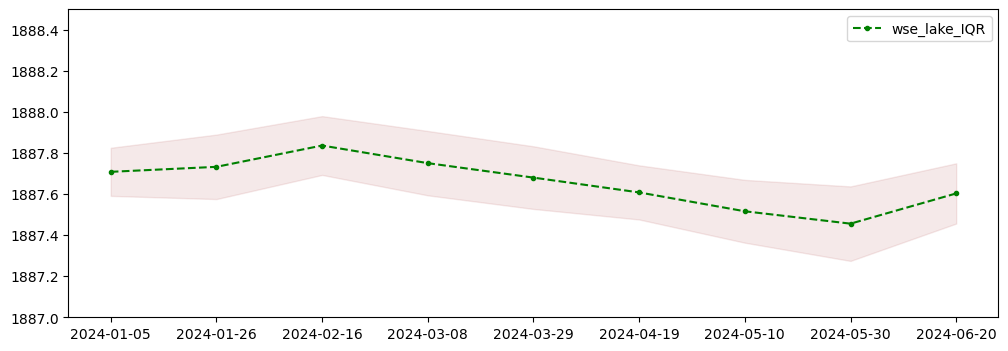

In [78]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(heights_dianchi_mean.keys(), heights_dianchi_mean.values(), '--.', color='green', label='wse_lake_IQR')
ax.fill_between(date_data, np.array([*heights_dianchi_mean.values()]) - np.array([*heights_dianchi_std.values()]), \
                np.array([*heights_dianchi_mean.values()]) + np.array([*heights_dianchi_std.values()]), color='Brown', alpha=0.1)
ax.set_ylim([1887, 1888.5])
ax.legend()
